# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


***Описание данных***


***Признаки***
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


***Целевой признак***
* Price — цена (евро)








## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
#выведем первые 5 строк датафрейма
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
#выведем основную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Мы видим пропущенные значения в столбцах: VehicleType, Gearbox, Model, FuelType, Repaired.
Также приведем название столбцов к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()

In [6]:
#приведем столбцы также к змеиному регистру
data = \
data.rename\
(columns={'datecrawled':'date_crawled','vehicletype':'vehicle_type', 'registrationyear': 'registration_year','registrationmonth': 'registration_month',\
         'fueltype': 'fuel_type', 'datecreated':'date_created','numberofpictures':'number_of_pictures', 'postalcode':'postal_code', 'lastseen':'last_seen'})
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
#проверим значения в столбце с фото
data['number_of_pictures'].value_counts()

0    354369
Name: number_of_pictures, dtype: int64

Удалим неинформативные столбцы, такие как:
 - date_crawled, postal_code, date_created, last_seen  - это личные данные пользователей
 - registration_month, оставим год регистрации, месяц не так важен
 - number_of_pictures, так как все значения нулевые  

In [8]:
data = data.drop \
(['date_crawled', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'number_of_pictures'], axis= 1)

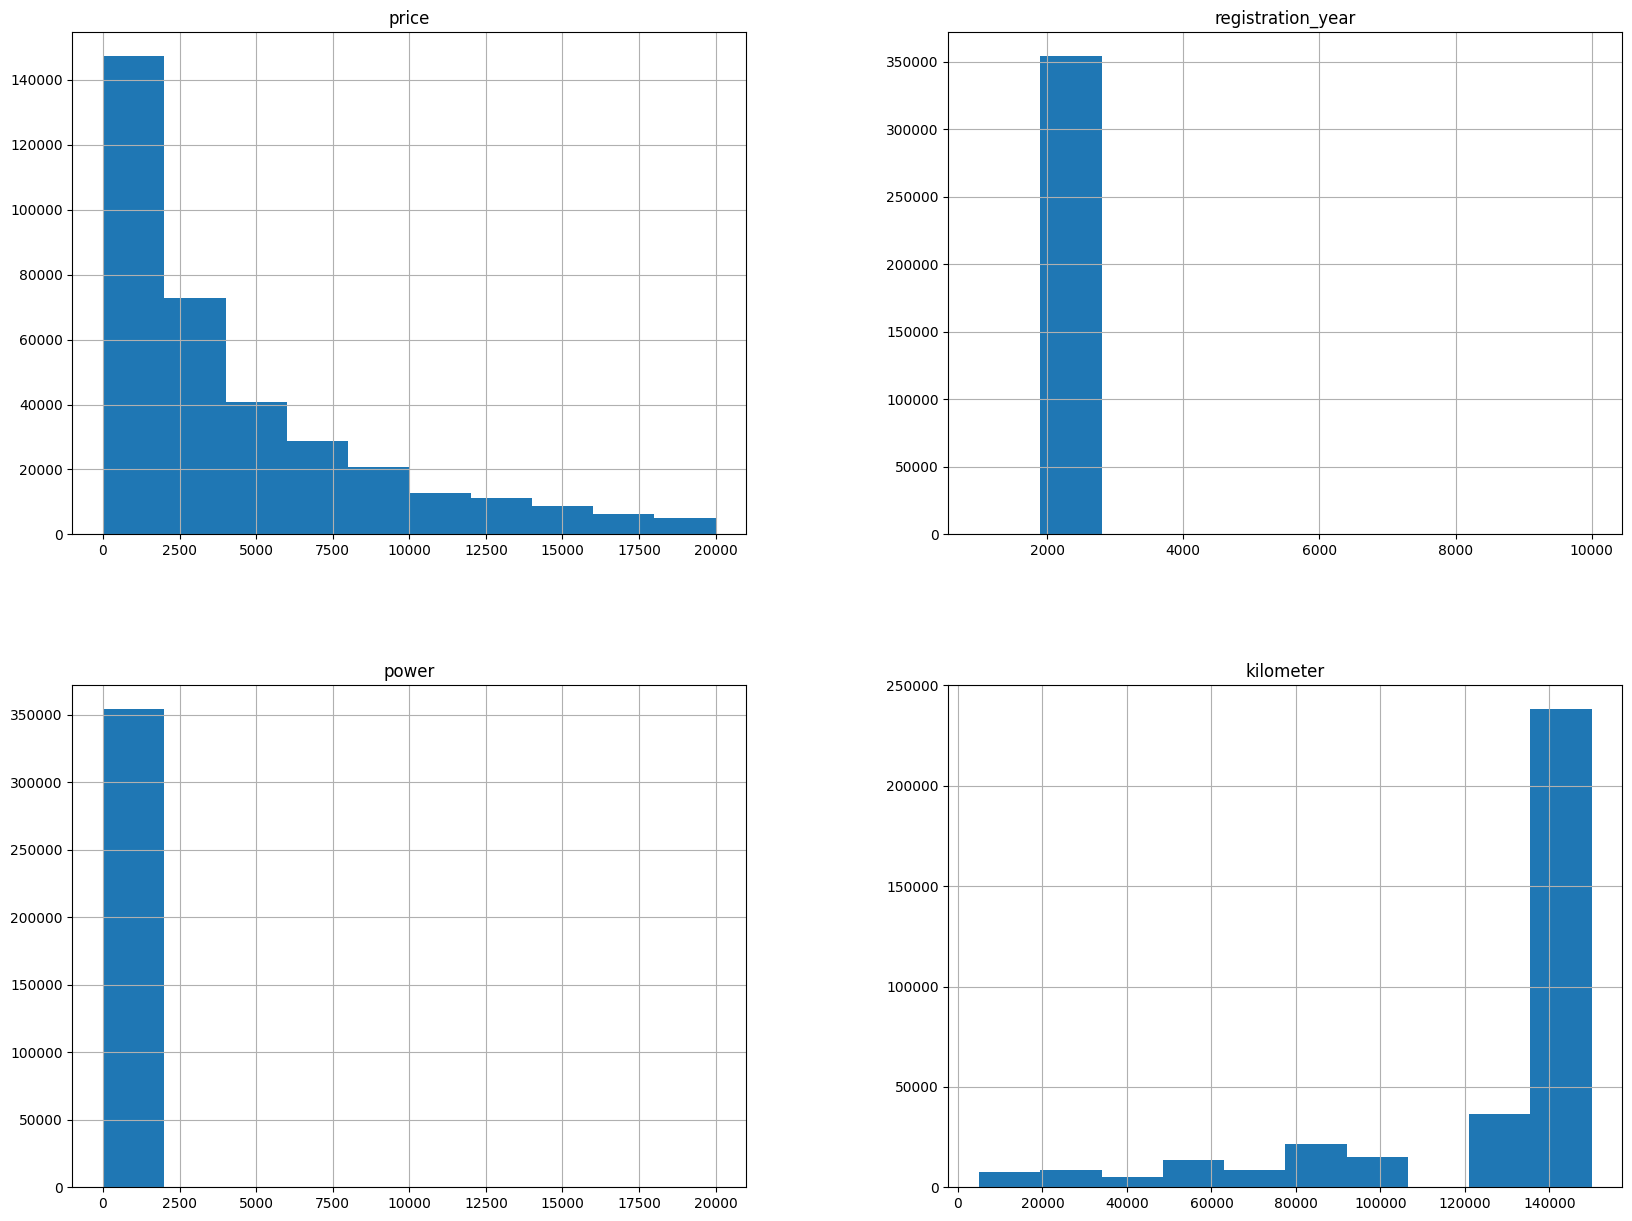

In [9]:
#посторим гистограммы
ax=data.hist(figsize=(20,15))

Мы видим, что в столбцах registration_year и power присутствуют анамально высокие значения.
В столбце price пик в нулевом значении.

In [10]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Здесь мы видим ошибочные значения, а также совсем старые автомобили.

In [11]:
#посмотрим на авто до 1960 года
data.loc[data['registration_year'] < 1960]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
1928,7000,suv,1945,manual,48,other,150000,petrol,volkswagen,no
2273,1800,convertible,1925,NaN,0,NaN,5000,NaN,sonstige_autos,no
3333,10500,sedan,1955,manual,30,other,60000,petrol,ford,NaN
...,...,...,...,...,...,...,...,...,...,...
351299,5500,bus,1956,manual,37,NaN,60000,petrol,sonstige_autos,no
351682,11500,NaN,1800,NaN,16,other,5000,petrol,fiat,NaN
353531,6000,sedan,1937,manual,38,other,5000,petrol,mercedes_benz,NaN
353961,200,NaN,1910,NaN,0,NaN,5000,petrol,sonstige_autos,NaN


In [12]:
#посчитаем процент таких значений от общего дататсета
round(len(data.loc[data['registration_year'] <= 1960]) / \
      len(data['registration_year']) * 100, 3)

0.172

In [13]:
#посмотрим на авто после 2016 года, так как это последний год скачивания анкеты из базы
data.loc[data['registration_year'] > 2016]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
48,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,gasoline,fiat,yes
57,2399,NaN,2018,manual,64,other,125000,NaN,seat,no
...,...,...,...,...,...,...,...,...,...,...
354112,3600,NaN,2017,manual,86,transit,150000,gasoline,ford,NaN
354140,1000,NaN,2017,manual,101,a4,150000,NaN,audi,NaN
354203,2140,NaN,2018,manual,80,fiesta,150000,NaN,ford,no
354253,1250,NaN,2018,NaN,0,corsa,150000,petrol,opel,NaN


In [14]:
round(len(data.loc[data['registration_year'] > 2016]) / \
      len(data['registration_year']) * 100, 3)

4.1

Удалим эти значения, так как данные ошибочны или не актуальны.

In [15]:
data = data.loc[(data['registration_year'] >= 1960) & (data['registration_year'] <= 2016)]

In [16]:
data['registration_year'].sort_values().unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016])

Посмотрим на значения в столбце power:

(0.0, 1000.0)

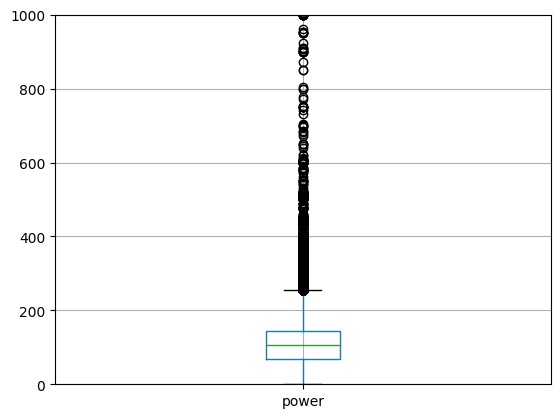

In [17]:
ax = data.boxplot(column=['power'])
plt.ylim (0, 1000)

По графику мы видим, что после 250 л.с. начинаются выбросы, также есть данные с нулевой мощностью, при этом медиана чуть больше 100 л.с.
Минимальную мощность будем рассматривать от 50 и максимульную до 1000 л.с.

In [18]:
#посмотрим на мощность более 1000
data.query('power > 1000')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,petrol,opel,yes
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN
7720,1500,small,2000,manual,1400,NaN,150000,petrol,honda,NaN
...,...,...,...,...,...,...,...,...,...,...
348668,1000,wagon,1996,manual,2598,a6,150000,NaN,audi,NaN
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no


Здесь мы видим явные ошибки (при ручном вводе или объединении данных), данные увеличены в 10 или 100 раз. C каждым значением нужно разбираться, посмотрим какой процент данных они составляют.

In [19]:
round(len(data.query('power > 1000')) / len(data['power']) * 100, 3)

0.081

In [20]:
data.query('power < 50')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


In [21]:
round(len(data.query('power < 50'))/ len(data['power']) * 100, 3)

12.344

Данные более 10 процентов, заполним нулевые значения в зависимости от модели авто:

In [22]:
for i in data['model'].unique():
    data.loc[(data['model'] == i) & \
    (data['power']== 0),'power'] = \
    data.loc[(data['model']==i),'power'].median() 

In [23]:
#проверим оставшиеся значения
data.query('power < 50')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
115,0,small,1999,NaN,0.0,NaN,5000,petrol,volkswagen,NaN
160,500,small,1999,manual,0.0,NaN,150000,petrol,renault,no
193,1200,coupe,1990,manual,45.0,NaN,150000,petrol,volkswagen,NaN
208,2250,small,2001,NaN,41.0,fortwo,150000,gasoline,smart,no
212,1200,small,2002,manual,45.0,lupo,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354266,399,small,1992,manual,45.0,polo,150000,petrol,volkswagen,NaN
354277,0,small,1999,manual,37.0,arosa,150000,petrol,seat,yes
354338,180,NaN,1995,NaN,0.0,NaN,125000,petrol,opel,NaN
354360,3999,wagon,2005,manual,3.0,3er,150000,gasoline,bmw,no


In [24]:
round(len(data.query('power < 50'))/ len(data['power']) * 100, 3)

3.361

Данные с пропущенными значениями в модели и нулевым значением мощности удалим.

In [25]:
data = data.loc[(data['power']>=50) & (data['power'] <= 1000)]

In [26]:
data.loc[(data['power']>=50) & (data['power'] <= 1000)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,98.0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190.0,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,120.0,zafira,150000,petrol,opel,no
354364,0,NaN,2005,manual,75.0,colt,150000,petrol,mitsubishi,yes
354366,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


In [27]:
#приведем столбец к целому числу
data['power'] = data['power'].astype('int')

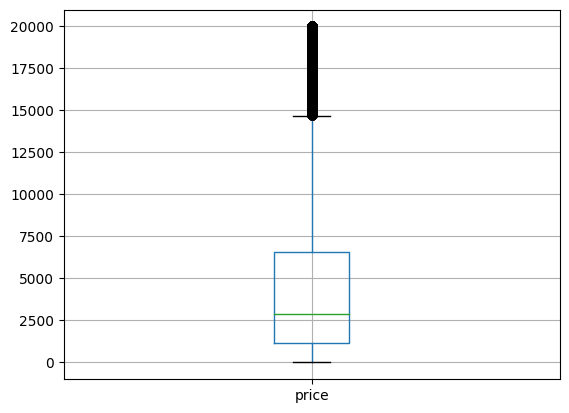

In [28]:
#посмотрим на цену
ax = data.boxplot(column=['price'])

Минимальная цена начинается с нуля, выбросы после 14500 евро, медиана около 3000 евро.

In [29]:
#рассмотрим авто с ценой меньше 50 евро
data.query('price < 50')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,60,corsa,150000,petrol,opel,NaN
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354158,0,NaN,2000,manual,55,punto,5000,petrol,fiat,yes
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN


In [30]:
#посчитаем количество от общего датасета
round(len(data.query('price < 50')) / len(data['price']) * 100, 3)

2.984

In [31]:
#оставляем цены выше 50 евро
data = data.loc[data['price'] >= 50]

In [32]:
#рассмотрим авто с ценой выше 15000 евро
data.query('price > 15000')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
179,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354210,17990,bus,2007,auto,174,transporter,125000,gasoline,volkswagen,no
354279,16500,suv,2013,manual,116,i_reihe,30000,gasoline,hyundai,no
354286,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes
354306,16999,wagon,2008,auto,269,a6,150000,gasoline,audi,no


Эти данные выглядят реалистично. Их мы оставим.

In [33]:
#посмотрим на пробег
data['kilometer'].value_counts()

150000    213669
125000     33376
100000     13382
90000      10713
80000       9323
70000       8006
60000       6965
50000       5769
40000       4581
30000       4010
5000        3820
20000       3407
10000        932
Name: kilometer, dtype: int64

Данные также выглядят реалистично.

Посмотрим на корреляцию между числовыми столбцами:

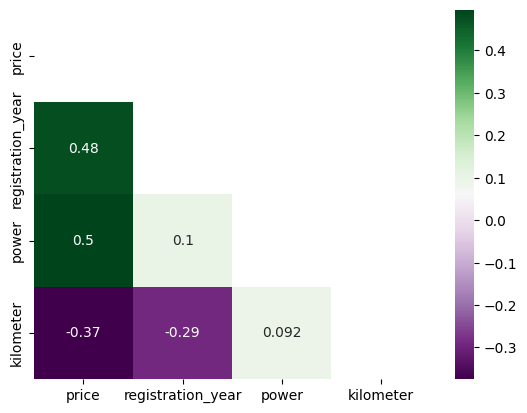

In [34]:
numeric = data[['price', 'registration_year','power','kilometer']]
matrix = np.triu(numeric.corr())
ax = sns.heatmap(numeric.corr(), annot = True, mask=matrix, cmap= 'PRGn')

Сильной корреляции между данными нет, есть небольшая между мощностью авто и ценой.

Посмотрим на пропуски в категориальных признаках:

In [35]:
#посчитаем количество пропущенных значений в процентах
(data.isna().sum() / len(data)).round(4) * 100

price                 0.00
vehicle_type          5.29
registration_year     0.00
gearbox               3.95
power                 0.00
model                 3.31
kilometer             0.00
fuel_type             6.49
brand                 0.00
repaired             17.16
dtype: float64

Заполним отстутствующие данные значением 'unknown':

In [36]:
data[['vehicle_type','gearbox', 'model','fuel_type','repaired']] = \
data[['vehicle_type', 'gearbox', 'model','fuel_type','repaired']].fillna('unknown')

In [37]:
#проверим дубликаты
data.duplicated().sum()

42372

In [38]:
#удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275581 entries, 0 to 275580
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              275581 non-null  int64 
 1   vehicle_type       275581 non-null  object
 2   registration_year  275581 non-null  int64 
 3   gearbox            275581 non-null  object
 4   power              275581 non-null  int64 
 5   model              275581 non-null  object
 6   kilometer          275581 non-null  int64 
 7   fuel_type          275581 non-null  object
 8   brand              275581 non-null  object
 9   repaired           275581 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.0+ MB


***Вывод:***

На данном этапе мы:

 - удалили неинформативные столбцы (личные данные и столбец с отстутсвием фото)
 - удалили аномальные значения в столбцах price и power
 - заполнили пропущенные значения в категориальных признаках
 - удалили дубликаты


## Обучение моделей

### Выборки

In [40]:
#выделим признаки и целевой признак
features = data.drop(['price'], axis=1)
target = data['price']

In [41]:
#выделим 60% для обучающей выборки
features_train, features_test1, target_train,target_test1 = \
train_test_split(features, target, test_size=0.4, random_state=12345)

In [42]:
#выделим валидационную и тестовую выборки
features_valid, features_test, target_valid,target_test = \
train_test_split(features_test1, target_test1, test_size=0.5, random_state=12345)

In [43]:
#выведем размеры, полученных таблиц
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(165348, 9)
(165348,)
(55116, 9)
(55116,)
(55117, 9)
(55117,)


### Модели

#### LGBMRegressor

Закодируем категориальные признаки для модели с помощью Ordinal Encoding:

In [44]:
#функция для кодирования признаков
categorial = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

ord_enc = OrdinalEncoder()
ord_enc.fit(features_train[categorial])

def ordinal_enc(features, columns):
    features[columns] = ord_enc.transform(features[columns])
    return features

In [45]:
features_train_ordinal = ordinal_enc(features_train, categorial)
features_train_ordinal

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
17093,4.0,1999,1.0,105,11.0,150000,6.0,2.0,1.0
237799,4.0,1996,1.0,122,59.0,150000,6.0,20.0,0.0
246905,8.0,2005,1.0,115,170.0,150000,6.0,38.0,0.0
251876,2.0,1997,1.0,133,166.0,150000,6.0,11.0,0.0
260704,2.0,2004,0.0,218,86.0,125000,6.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
158838,4.0,1991,1.0,109,166.0,150000,6.0,20.0,2.0
47873,5.0,1999,1.0,58,75.0,60000,6.0,27.0,0.0
86398,0.0,2002,2.0,101,249.0,70000,6.0,24.0,1.0
77285,4.0,2006,1.0,129,11.0,60000,6.0,2.0,0.0


In [46]:
features_valid_ordinal = ordinal_enc(features_valid, categorial)
features_valid_ordinal

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
161631,4.0,1989,1.0,75,116.0,150000,6.0,38.0,0.0
230489,5.0,2006,1.0,163,6.0,150000,2.0,2.0,1.0
204252,7.0,2016,1.0,150,166.0,150000,6.0,22.0,0.0
222821,1.0,2001,0.0,192,11.0,150000,7.0,2.0,0.0
170666,4.0,2007,0.0,231,95.0,125000,6.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...
77503,0.0,2009,1.0,116,237.0,150000,2.0,20.0,0.0
124389,0.0,2004,1.0,101,166.0,150000,2.0,5.0,0.0
196677,5.0,1995,1.0,60,83.0,150000,6.0,24.0,1.0
226199,1.0,1998,1.0,110,158.0,150000,6.0,19.0,1.0


Подберем параметры с помощью GridSearch:

In [47]:
%%time

estimator = lgb.LGBMRegressor()
grid_params = {
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [100, 200, 500],
}
gbm = GridSearchCV(estimator, grid_params, scoring ='neg_root_mean_squared_error')
gbm.fit(features_train_ordinal, target_train)
print(gbm.best_estimator_)
print(gbm.best_score_)
print(gbm.best_params_)

LGBMRegressor(n_estimators=500)
-1632.4734549281436
{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500}
CPU times: user 9min 28s, sys: 1min 35s, total: 11min 3s
Wall time: 1min 32s


In [48]:
%%time

target_pred_gbm = gbm.predict(features_valid_ordinal)
result_gbm = mean_squared_error(target_valid, target_pred_gbm) ** 0.5
print('RMSE на валидационной выборке:', result_gbm)

RMSE на валидационной выборке: 1614.2440978661496
CPU times: user 1.83 s, sys: 41.8 ms, total: 1.87 s
Wall time: 256 ms


In [49]:
#сохраним время обучения и предсказания
time_train_gbm = "1min 32s"
time_pred_gbm = "256 ms"

#### CatBoostRegressor

In [50]:
%%time

cbr = CatBoostRegressor()


grid_param = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300, 400, 500]}
gs_cbr = GridSearchCV (estimator = cbr, param_grid = grid_param, scoring ='neg_root_mean_squared_error')
gs_cbr.fit(features_train,target_train)


print(gs_cbr.best_estimator_)
print(gs_cbr.best_score_)
print(gs_cbr.best_params_)

Learning rate set to 0.5
0:	learn: 3541.4940820	total: 65.5ms	remaining: 6.48s
1:	learn: 3052.0435472	total: 69.7ms	remaining: 3.42s
2:	learn: 2753.2560677	total: 73.2ms	remaining: 2.37s
3:	learn: 2563.9129786	total: 77ms	remaining: 1.85s
4:	learn: 2463.9631441	total: 80.7ms	remaining: 1.53s
5:	learn: 2387.2969616	total: 84.2ms	remaining: 1.32s
6:	learn: 2325.6692934	total: 87.7ms	remaining: 1.16s
7:	learn: 2292.6318230	total: 91.2ms	remaining: 1.05s
8:	learn: 2252.4584616	total: 94.9ms	remaining: 960ms
9:	learn: 2223.1031015	total: 98.6ms	remaining: 887ms
10:	learn: 2198.1872875	total: 103ms	remaining: 830ms
11:	learn: 2185.2500285	total: 106ms	remaining: 778ms
12:	learn: 2158.5585236	total: 110ms	remaining: 733ms
13:	learn: 2135.7047128	total: 113ms	remaining: 696ms
14:	learn: 2119.9037927	total: 117ms	remaining: 661ms
15:	learn: 2104.5914884	total: 120ms	remaining: 629ms
16:	learn: 2087.8878578	total: 123ms	remaining: 601ms
17:	learn: 2075.6763078	total: 126ms	remaining: 576ms
18:	l

In [51]:
%%time

target_pred_cbr = gs_cbr.predict(features_valid)
result_cbr = mean_squared_error(target_valid, target_pred_cbr) ** 0.5
print('RMSE на валидационной выборке:', result_cbr)

RMSE на валидационной выборке: 1659.3714576684833
CPU times: user 48.4 ms, sys: 5.3 ms, total: 53.7 ms
Wall time: 14.4 ms


In [52]:
#сохраним время обучения и предсказания
time_train_cbr = "1min 26s"
time_pred_cbr = "14.4 ms"

#### RandomForestRegressor

In [53]:
%%time

best_model_forest = None
best_result_forest = 0
best_est_forest = 0
for est in range(300,500,50):
    model = \
    RandomForestRegressor(random_state=12345, \
    n_estimators= est)
    model.fit(features_train_ordinal, target_train)
    pred_train_forest = model.predict(features_train_ordinal)
    res_forest= mean_squared_error(target_train, pred_train_forest) ** 0.5
    if res_forest > best_result_forest:
        best_model_forest = model
        best_result_forest = res_forest
        best_est_forest = est
print ("Количество деревьев:", best_est_forest) 
print ("RMSE лучшей модели на обучающей выборке:",\
       best_result_forest)

Количество деревьев: 300
RMSE лучшей модели на обучающей выборке: 939.5273735654216
CPU times: user 7min 19s, sys: 7.62 s, total: 7min 26s
Wall time: 7min 30s


In [54]:
%%time

target_pred_forest = best_model_forest.predict(features_valid_ordinal)
res_valid_forest = mean_squared_error(target_valid, target_pred_forest) ** 0.5
print('RMSE на валидационной выборке:', res_valid_forest)

RMSE на валидационной выборке: 1706.1768111483161
CPU times: user 3.93 s, sys: 936 ms, total: 4.87 s
Wall time: 8.83 s


In [55]:
#сохраним время обучения и предсказания
time_train_forest = "7min 30s"
time_pred_forest = "8.83 s"

#### LinearRegression

Закодируем данные для модели с помощью OHE:

In [57]:
numeric = ['registration_year', 'power', 'kilometer']

ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe.fit(features_train[categorial])
new_col = ohe.get_feature_names_out(categorial)

def one_hot(features):
    features_ohe = pd.DataFrame \
    (ohe.transform(features[categorial]).toarray(), columns = new_col, index = features.index)
    features_ohe  = features_ohe.join(features[numeric])
    return features_ohe

In [58]:
features_train_ohe = one_hot(features_train)
features_train_ohe

,vehicle_type_1.0,vehicle_type_2.0,vehicle_type_3.0,vehicle_type_4.0,vehicle_type_5.0,vehicle_type_6.0,vehicle_type_7.0,vehicle_type_8.0,gearbox_1.0,gearbox_2.0,...,brand_35.0,brand_36.0,brand_37.0,brand_38.0,brand_39.0,repaired_1.0,repaired_2.0,registration_year,power,kilometer
17093,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1999,105,150000
237799,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1996,122,150000
246905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2005,115,150000
251876,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997,133,150000
260704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004,218,125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158838,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1991,109,150000
47873,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999,58,60000
86398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2002,101,70000
77285,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006,129,60000


In [59]:
features_valid_ohe = one_hot(features_valid)
features_valid_ohe

,vehicle_type_1.0,vehicle_type_2.0,vehicle_type_3.0,vehicle_type_4.0,vehicle_type_5.0,vehicle_type_6.0,vehicle_type_7.0,vehicle_type_8.0,gearbox_1.0,gearbox_2.0,...,brand_35.0,brand_36.0,brand_37.0,brand_38.0,brand_39.0,repaired_1.0,repaired_2.0,registration_year,power,kilometer
161631,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1989,75,150000
230489,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2006,163,150000
204252,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,150,150000
222821,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001,192,150000
170666,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007,231,125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009,116,150000
124389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004,101,150000
196677,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1995,60,150000
226199,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1998,110,150000


Cтандартизируем их для линейной регрессии:

In [60]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_train_ohe.head()

,vehicle_type_1.0,vehicle_type_2.0,vehicle_type_3.0,vehicle_type_4.0,vehicle_type_5.0,vehicle_type_6.0,vehicle_type_7.0,vehicle_type_8.0,gearbox_1.0,gearbox_2.0,...,brand_35.0,brand_36.0,brand_37.0,brand_38.0,brand_39.0,repaired_1.0,repaired_2.0,registration_year,power,kilometer
17093,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.594269,-0.311580,0.597088
237799,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.052652,0.005104,0.597088
246905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322498,-0.125296,0.597088
251876,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.899858,0.210017,0.597088
260704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169703,1.793437,-0.069705


In [61]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train)
pred_lr = model_lr.predict(features_train_ohe)
res_lr = mean_squared_error(target_train, pred_lr)** 0.5
print ("RMSE на обучающей выборке:",\
       res_lr)

RMSE на обучающей выборке: 2644.340617915214
CPU times: user 16.2 s, sys: 1.61 s, total: 17.9 s
Wall time: 3.96 s


In [62]:
%%time

valid_pred_lr = model_lr.predict(features_valid_ohe)
res_valid_lr = mean_squared_error(target_valid, valid_pred_lr) ** 0.5
print('RMSE на валидационной выборке:', res_valid_lr )

RMSE на валидационной выборке: 2635.3865577288675
CPU times: user 554 ms, sys: 145 ms, total: 699 ms
Wall time: 111 ms


In [63]:
#сохраним время обучения и предсказания
time_train_lr = "3.96 s"
time_pred_lr = "111 ms"

## Анализ моделей

Объединим результат в таблицу:

In [64]:
result = {'model_name':\
['LGBMRegressor','CatBoostRegressor','RandomForestRegressor', 'LinearRegression'],\
'RMSE_valid':[result_gbm, result_cbr,res_valid_forest,res_valid_lr],\
        'time_train':[time_train_gbm, time_train_cbr, time_train_forest, time_train_lr],
        'time_pred':[time_pred_gbm, time_pred_cbr, time_pred_forest, time_pred_lr]}
result = pd.DataFrame(result)
result.\
sort_values(by='RMSE_valid').\
reset_index(drop = True)

,model_name,RMSE_valid,time_train,time_pred
0,LGBMRegressor,1614.244098,1min 25s,259 ms
1,CatBoostRegressor,1659.371458,1min 28s,12.4 ms
2,RandomForestRegressor,1706.176811,20min 50s,8.11 s
3,LinearRegression,2635.386558,2.94 s,102 ms


Мы видим, что лучший результат RMSE на валидационной выборке показала модель LGBMRegressor, в том числе мы получили быстрые результаты обучения и предсказания.
Так же хочется отметить CatBoostRegressor с хорошими результатами по времени и метрике.

## Проверка лучшей модели

In [65]:
#закодируем данные для тестовой выборки:
features_test_ordinal = ordinal_enc(features_test, categorial)
features_test_ordinal

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
188843,7.0,2005,1.0,145,112.0,150000,6.0,10.0,1.0
117161,8.0,2003,1.0,126,174.0,150000,2.0,23.0,0.0
55663,5.0,1999,1.0,105,49.0,150000,6.0,38.0,2.0
29893,4.0,2003,1.0,60,176.0,150000,6.0,9.0,0.0
104523,1.0,2006,0.0,61,106.0,60000,6.0,32.0,0.0
...,...,...,...,...,...,...,...,...,...
68236,0.0,2003,1.0,109,166.0,150000,2.0,36.0,0.0
52817,7.0,2000,1.0,90,116.0,150000,6.0,38.0,0.0
114134,5.0,2002,0.0,75,226.0,150000,6.0,27.0,0.0
209604,8.0,2006,0.0,163,59.0,150000,6.0,20.0,0.0


In [66]:
%%time

target_test_pred = gbm.predict(features_test_ordinal)
result_test = mean_squared_error(target_test, target_test_pred) ** 0.5
print('RMSE на тестовой выборке:', result_test)

RMSE на тестовой выборке: 1634.9222479547836
CPU times: user 2.1 s, sys: 220 ms, total: 2.32 s
Wall time: 337 ms


На тестовой выборке модель LGBMRegressor показала себя хорошо, результат несильно оличается от валидационной выборки.

## Общий вывод

В данном исследовании мы выполнили следующие шаги:
  - провели предобработку данных: удалили неинформативные для моделей столбцы, выявили аномалии, заполнили пропущенные значения, удалили дубликаты
  - разделили данные на обучающую, валидационную и тестовую выборку
  - для моделей LGBMRegressor и RandomForestRegressor сделали кодирование категориальных признаков с помощью Ordinal Encoding
  - для модели LinearRegression закодировали признаки с помощью OneHotEncoder
  - обучили модели и проверили на валидационной выборке с помощью метрики RMSE
  - оценили время, потраченное моделями на обучение и предсказание
  - по качеству предсказания и потраченному времени на обучение и предсказание выявили лучшую модель - LGBMRegressor
  - провели тестирование лучшей модели и получили результат: RMSE = 1634.9222479547836 и время предсказания 337 ms
  